In [2]:
import arff
import math
import graphviz
import pprint
import numpy as np

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

pp = pprint.PrettyPrinter(depth = 6)

### Algorytm TAN - Tree Augumented Naive Bayes  
<img src="img/TAN-algo.png" style="height: 200px">
<img src="img/TAN-prob.png" style="height: 100px">

In [22]:
class TANAlgorithm(object):
    def __init__(self, attributes, test_data):
        self.test_data = test_data
        self.attributes = attributes
    
    def find_net(self):
        computed_net = self.construct_basic_naive_net()
        weights, connections = self.compute_all_weights()
        
        spanning_tree = minimum_spanning_tree(csr_matrix(weights)).toarray().astype(int)
        
        return self.update_computed_net_with_spanning_tree(spanning_tree, computed_net)
    
    def update_computed_net_with_spanning_tree(self, spanning_tree, computed_net):
        for i, row in enumerate(spanning_tree):
            for j, cell in enumerate(row):
                if cell != 0:
                    start = self.attributes[i + 1]['name']
                    end = self.attributes[j + 1]['name']   
                    computed_net = self.update_net_with_new_connection(computed_net, start, end)
        return computed_net
        
    
    def update_net_with_new_connection(self, net, new_parent_name, node_name):
        for node in net:
            if node['name'] == node_name:
                node['parents'].append({'name': new_parent_name, 'q': self.find_node_states(new_parent_name)})
        return net
    
    def construct_basic_naive_net(self):
        computed_net = []
        class_attribute = self.attributes[0]
        
        # Konstruowanie bazowej naiwnej sieci
        for i, attribute in enumerate(self.attributes):
            # Algorytm zakłada, ze pierwszy element w 'attributes' to klasa
            if (i == 0): 
                computed_net.append({'name': attribute['name'], 'r': attribute['states'], 'parents': []})
                continue
                
            computed_net.append({'name': attribute['name'], 'r': attribute['states'], 'parents': [{'name': class_attribute['name'], 'q': class_attribute['states']}]})
        
        return computed_net
    
    def compute_all_weights(self):
        class_attribute = self.attributes[0]
        connections = []
        
        size = len(self.attributes) - 1
        weights = np.zeros((size, size))
            
        for attribute_index in range(1, len(self.attributes)):
            for second_attribute_index in range(attribute_index + 1, len(self.attributes)):
                first_attribute = self.attributes[attribute_index]
                second_attribute = self.attributes[second_attribute_index]

                weight = self.compute_weight(first_attribute, second_attribute, class_attribute) * 100
                weights[attribute_index - 1, second_attribute_index - 1] = weight
                
                connections.append({'start': first_attribute['name'], 'end': second_attribute['name'], 'weight': weight})
        
        return (weights, connections)
    
    def find_node_states(self, node_name):
        for attribute in self.attributes:
            if attribute['name'] == node_name:
                return attribute['states']
        raise ValueError("No such node: " + node_name)
    
    def compute_weight(self, first_argument, second_argument, class_argument):
        result = 0
        
        class_name = class_argument['name']
        first_name = first_argument['name']
        second_name = second_argument['name']
        first_argument_states = first_argument['states']
        second_argument_states = second_argument['states']
        class_argument_states = class_argument['states']
        
        for first_state in first_argument_states:
            for second_state in second_argument_states:
                for class_state in class_argument_states:
                    p_c = self.compute_probability(class_name, class_state)
                    p_x1_given_c = self.compute_conditional_probability(first_name, first_state, class_name, class_state)
                    p_x2_given_c = self.compute_conditional_probability(second_name, second_state, class_name, class_state)
                    p_x1_x2_given_c = self.compute_double_conditional_probability((first_name, first_state), (second_name, second_state), (class_name, class_state))
                    p_c_x1_x2 = p_c * p_x1_given_c * p_x2_given_c
                    
                    result += p_c_x1_x2 * math.log10(float(p_x1_x2_given_c) / (p_x1_given_c * p_x2_given_c))
     
        return result
    
    def compute_probability(self, argument, argument_state):
        #print("P(" + argument + " = " + argument_state + ")")
        #i.e. P(play = yes)
        number_of_occurences = self.count_number_of_occurences_in_test_data(argument, argument_state)
        return number_of_occurences / len(self.test_data)
    
    def compute_conditional_probability(self, argument, argument_state, condition, condition_state):
        #print("P(" + argument + " = " + argument_state + " | " + condition + " = " + condition_state + ")")
        #i.e. P(outlook = sunny | play = yes)
        number_of_join_occurences = self.count_double_number_of_occurences_in_test_data((argument, argument_state), (condition, condition_state))
        number_of_condition_occurences = self.count_number_of_occurences_in_test_data(condition, condition_state)
        
        if (number_of_join_occurences == 0 or number_of_condition_occurences == 0):
            return 1 / len(self.attributes[0]['states'])
            
        return number_of_join_occurences / number_of_condition_occurences
    
    def compute_double_conditional_probability(self, first_argument, second_argument, condition):
        #print("P(" + first_argument[0] + " = " + first_argument[1] + ", " + second_argument[0] + " = " + second_argument[1] + " | " + condition[0] + " = " + condition[1] + ")")
        #i.e. P(outlook = sunny, windy = TRUE | play = yes)
        number_of_join_occurences = self.count_triple_number_of_occurences_in_test_data(first_argument, second_argument, condition)
        number_of_condition_occurences = self.count_number_of_occurences_in_test_data(condition[0], condition[1])
        
        if (number_of_join_occurences == 0 or number_of_condition_occurences == 0):
            return 1 / len(self.attributes[0]['states'])
        
        return number_of_join_occurences / number_of_condition_occurences
    
    def count_number_of_occurences_in_test_data(self, name, state):
        count = 0
        for sample in self.test_data:
            if (sample[name] == state):
                count += 1
        return count
    
    def count_double_number_of_occurences_in_test_data(self, first, second):
        count = 0
        for sample in self.test_data:
            if (sample[first[0]] == first[1] and sample[second[0]] == second[1]):
                count += 1
        return count
    
    def count_triple_number_of_occurences_in_test_data(self, first, second, third):
        count = 0
        for sample in self.test_data:
            if (sample[first[0]] == first[1] and sample[second[0]] == second[1] and sample[third[0]] == third[1]):
                count += 1  
        return count

------

### Ładowanie pliku ARFF

In [24]:
with open('data/weather.arff') as fh:
    data = arff.load(fh)
    
    attributes = []
    for i, p in enumerate(data['attributes']):
        attributes.append({'name': p[0], 'states': p[1]})
    
    sample_data = []
    for i, p in enumerate(data['data']):
        temp_dict = {}
        for j, d in enumerate(p):
            temp_dict.update({attributes[j]['name']: d})
        sample_data.append(temp_dict)

------

### Wybór argumentu - klasy

In [25]:
    index_of_class_attribute = 4
    print("Class argument: ")
    pp.pprint(attributes[index_of_class_attribute])
    
    final_attributes = []
    final_attributes.append(attributes[index_of_class_attribute])
    
    for i, attribute in enumerate(attributes):
        if i != index_of_class_attribute:
            final_attributes.append(attribute)

Class argument: 
{'name': 'play', 'states': ['yes', 'no']}


-----
### Główne wywołanie algorytmu i rysowanie grafu

[{'name': 'play', 'r': ['yes', 'no'], 'parents': []}, {'name': 'outlook', 'r': ['sunny', 'overcast', 'rainy'], 'parents': [{'name': 'play', 'q': ['yes', 'no']}]}, {'name': 'temperature', 'r': ['hot', 'mild', 'cool'], 'parents': [{'name': 'play', 'q': ['yes', 'no']}]}, {'name': 'humidity', 'r': ['high', 'normal'], 'parents': [{'name': 'play', 'q': ['yes', 'no']}, {'name': 'outlook', 'q': ['sunny', 'overcast', 'rainy']}]}, {'name': 'windy', 'r': ['TRUE', 'FALSE'], 'parents': [{'name': 'play', 'q': ['yes', 'no']}, {'name': 'temperature', 'q': ['hot', 'mild', 'cool']}, {'name': 'humidity', 'q': ['high', 'normal']}]}]


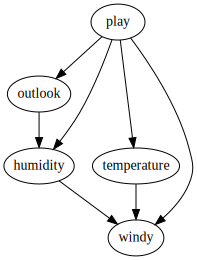

In [26]:
new_computed_net = TANAlgorithm(final_attributes, sample_data).find_net()

print(new_computed_net)

graph = graphviz.Digraph('generated graph')        
for node in new_computed_net:
    if not node['parents']:
        graph.node(node['name'] , label = node['name'])
    else:
        for parent in node['parents']:
            graph.edge(parent['name'], node['name'])          
graph